$\textbf{Selection of Depth and Areal Regions}$

$\text{In this tutorial we will see how to select the best region in the dataset using the PyCCAPT calibration module.}$

In [1]:
# Activate intractive functionality of matplotlib
%matplotlib ipympl
# import libraries
import os
import numpy as np
import sys
import logging
import os.path as path
import matplotlib.pyplot as plt
from ipywidgets import fixed, interact_manual, widgets

# Local module and scripts
from pyccapt.calibration.calibration_tools import variables, data_loadcrop, tools, data_tools
from pyccapt.calibration.calibration_tools import widgets as wd
from pyccapt.calibration.calibration_tools import dataset_path_qt
from pyccapt.calibration.mc import mc_tools
from pyccapt.calibration.leap_tools import ccapt_tools, leap_tools

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
 %reload_ext autoreload

In [4]:
# Disable showing logging in Jupyter notebook
logging.disable(sys.maxsize)

In [5]:
button = widgets.Button(
    description='load dataset',
)

@button.on_click
def open_file_on_click(b):
    global dataset_path
    dataset_path = dataset_path_qt.gui_fname().decode('ASCII')
button

Button(description='load dataset', style=ButtonStyle())

In [6]:
# check pytables library and install it
try:
    import tables
except:
    !conda install --yes --prefix {sys.prefix} pytables

In [7]:
tdc, det_diam, pulse_mode, flightPathLength_d, t0_d, max_tof, max_mc = wd.dataset_tdc_selection()
display(tdc, pulse_mode, max_tof, flightPathLength_d, det_diam,  t0_d, max_mc)

Dropdown(description='Data mode:', options=('surface_concept', 'roentdec', 'leap_epos', 'leap_pos'), value='su…

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

IntText(value=5000, description='Max tof:')

FloatText(value=110.0, description='Flight path length:')

FloatText(value=78.0, description='Detector diameter:')

FloatText(value=54.0, description='t0:')

FloatText(value=400.0, description='Max mc:')

$\text{Path to the dataset}$

In [8]:

dataset_main_path = os.path.dirname(dataset_path)
dataset_name_with_extention = os.path.basename(dataset_path)
dataset_name = os.path.splitext(dataset_name_with_extention)[0]

variables.init()

variables.result_path = dataset_main_path + '/' + dataset_name + '/load_crop/'
if not os.path.isdir(variables.result_path):
    os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
    
        
# dataset name
filename = dataset_path
savename = variables.result_path + '//' + dataset_name + '_cropped' + '.h5'

# Create data farame out of hdf5 file dataset
dld_group_storage = data_loadcrop.fetch_dataset_from_dld_grp(filename, tdc=tdc.value, pulse_mode=pulse_mode.value, max_tof=max_tof.value, det_diam=det_diam.value)

print('Total number of Ions:', len(dld_group_storage))

Filename>> D:/pyccapt/tests/data/OLO_W_6-1_data.h5
{'dld': ['high_voltage', 'pulse_voltage', 'start_counter', 't', 'x', 'y'], 'oxcart': ['high_voltage', 'main_chamber_vacuum', 'num_events', 'pulse_voltage', 'temperature', 'time_counter'], 'tdc': ['channel', 'high_voltage', 'pulse_voltage', 'start_counter', 'time_data'], 'time': ['time_h', 'time_m', 'time_s']}
Total number of Ions: 2000299


$\textbf {Crop and select the stable projection(right side) of below plotted graph}$
<br>
<br>
$\text{In the Experiment history plot below you should select the ions. After selectiong the ions with a rectangle you can continue and run the next cell. }$

In [9]:
dld_group_storage

,high_voltage (V),pulse (V),start_counter,t (ns),x_det (cm),y_det (cm)
0,500.000000,500.000000,47882.0,4317.172722,-0.404327,-0.557143
1,500.000000,500.000000,15008.0,3103.052976,3.180490,-1.028327
2,500.000000,500.000000,34383.0,157.061916,2.909878,-0.757714
3,500.000000,500.000000,51601.0,1876.369374,0.706776,1.353061
4,500.000000,500.000000,2899.0,193.848228,-2.706122,2.448245
...,...,...,...,...,...,...
2000294,8007.954102,8007.954102,58639.0,756.485406,-0.028653,1.184327
2000295,8007.954102,8007.954102,59193.0,754.380000,0.044571,1.165224
2000296,8007.954102,8007.954102,59570.0,755.929908,0.853224,-1.795592
2000297,8007.954102,8007.954102,59610.0,767.691378,2.454612,-1.445388


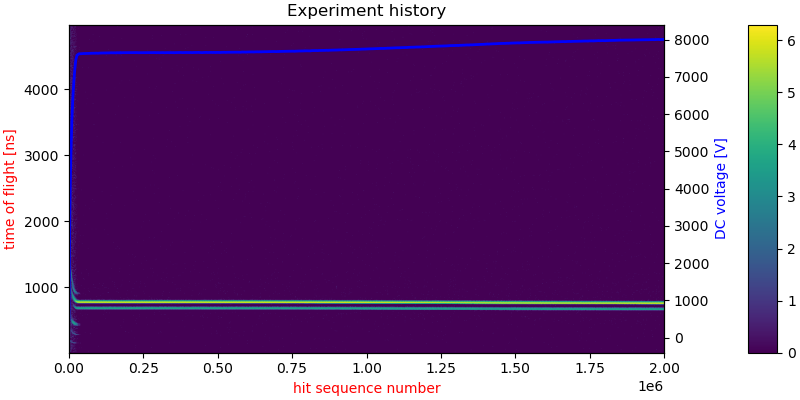

In [10]:
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, save_name = variables.result_path + '//ex_hist_' + dataset_name)

$\text{Boundaries of the selected(cropped) part of the graph is printed below}$

In [11]:
# Crop the dataset
print('Min Idx:', variables.selected_x1, 'Max Idx:', variables.selected_x2)
data_crop = data_loadcrop.crop_dataset(dld_group_storage)

Min Idx: 44695.160563507 Max Idx: 1979605.5315938937


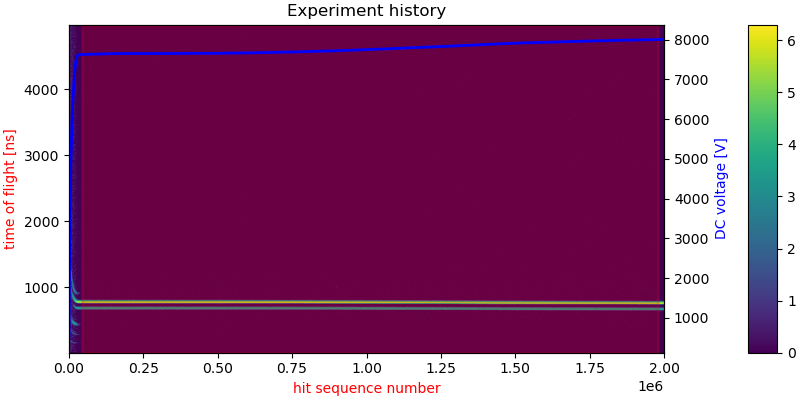

In [12]:
# Plot and selected experiment history
data_loadcrop.plot_crop_experimetn_history(dld_group_storage, rect=True, save_name=variables.result_path + '//ex_hist_slected_' + dataset_name)

$\textbf {ROI selcetion}$
<br>
<br>
$\text {Select the region of maximum concentration of electrons in the below plotted graph to utlize relevant data}$

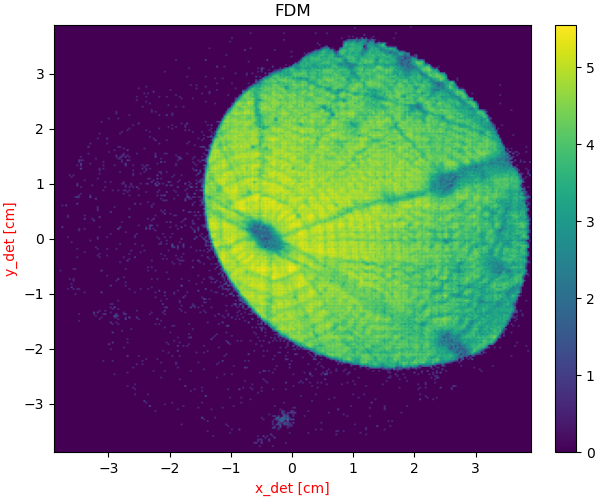

In [13]:
# Plot and select the FDM
data_loadcrop.plot_crop_FDM(data_crop,  bins=(256,256), save_name = variables.result_path + '//FDM_' + dataset_name)

$\text {The region selected in the previous step is displayed below.}$

x: 1.1889523724987616 y: 0.5533427470962233 roi: 2.500376666445985


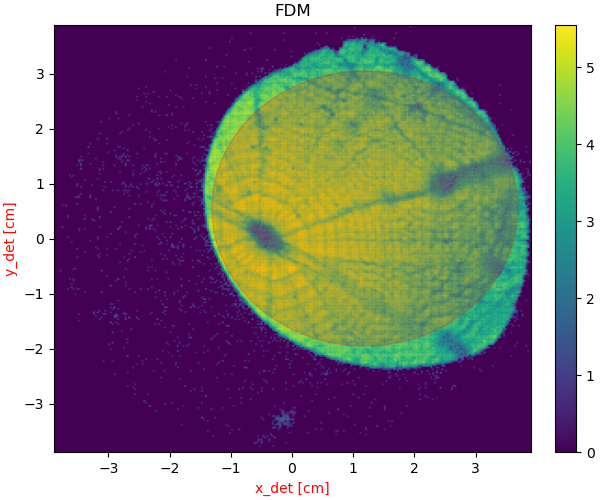

In [14]:
# plot selected area in FDM
data_loadcrop.plot_crop_FDM(data_crop, bins=(256,256), save_name = variables.result_path + '//FDM_c_' + dataset_name, circle=True)

$\text {The final selected data after processing is shown below.}$

d:\pyccapt\pyccapt\calibration\calibration_tools\data_loadcrop.py:235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop.drop(np.where(mask_fdm)[0], inplace=True)


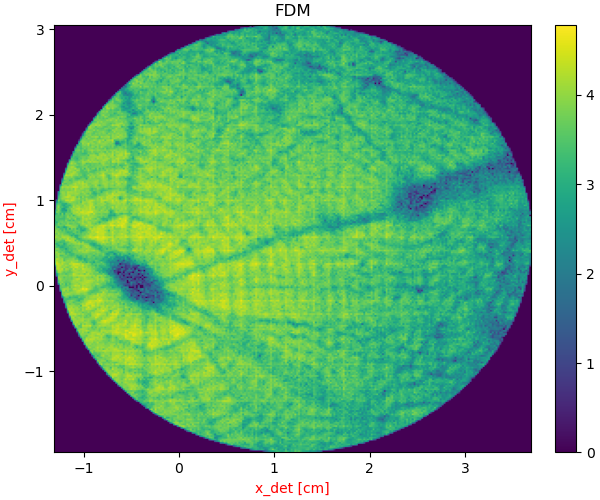

In [15]:
# Crop and plot the dataset
data_crop_FDM = data_loadcrop.crop_data_after_selection(data_crop)
data_loadcrop.plot_crop_FDM(data_crop_FDM, bins=(256,256), save_name = variables.result_path + '//FDM_crop_' + dataset_name, only_plot=True)

In [16]:
# calculate Pulses since last event pulse and Ions per pulse
counter = data_crop_FDM['start_counter'].to_numpy()

pulse_pi = np.zeros(len(counter))
ion_pp = np.zeros(len(counter))
temp = counter[0]
multi_hit_count = 1
pulse_to_previous_ion = 0
for i in range(len(counter)):

    if i+2 > len(counter):
        ion_pp[i] = multi_hit_count
        pulse_pi[i] = counter[i] - counter[i-1]
    else:
        if temp == counter[i+1]:
            multi_hit_count = multi_hit_count + 1
        else:
            if i != 0:
                temp = counter[i-1]
                pulse_to_previous_ion = counter[i] - temp
            else:
                pulse_to_previous_ion = 0
            for j in range(multi_hit_count):
                if j == 0:
                    ion_pp[i+j] = multi_hit_count
                    pulse_pi[i+j] = pulse_to_previous_ion
                elif j != 0 or i == 0:
                    ion_pp[i+j] = 0
                    pulse_pi[i+j] = 0
            multi_hit_count = 1


# add two calculated array to the croped dataset
data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


C:\Users\APTUser\AppData\Local\Temp\ipykernel_11816\3416479450.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['pulse_pi'] = pulse_pi.astype(np.uintc)
C:\Users\APTUser\AppData\Local\Temp\ipykernel_11816\3416479450.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM['ion_pp'] = ion_pp.astype(np.uintc)


$\text {The final dataset is saved and the percentage of loss in TOF croption is prited.}$

In [17]:
# save the cropped data

print('tof Crop Loss {:.2f} %'.format(((1 - len(data_crop_FDM) / len(dld_group_storage)) * 100)))

tof Crop Loss 15.13 %


In [18]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data_crop_FDM['high_voltage (V)'].to_numpy()
if pulse_mode.value == 'voltage':
    dld_pulseVoltage = data_crop_FDM['pulse (V)'].to_numpy()
elif pulse_mode.value == 'laser':
    dld_pulseVoltage = data_crop_FDM['pulse (deg)'].to_numpy()
dld_t = data_crop_FDM['t (ns)'].to_numpy()
dld_x = data_crop_FDM['x_det (cm)'].to_numpy()
dld_y = data_crop_FDM['y_det (cm)'].to_numpy()

mc_seb_ini = mc_tools.tof2mc(dld_t, t0_d.value, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength_d.value, mode=pulse_mode.value)

data_crop_FDM.insert(0, 'x (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(1, 'y (nm)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(2,'z (nm)', np.zeros(len(mc_seb_ini)))

data_crop_FDM.insert(3,'mc_c (Da)', np.zeros(len(mc_seb_ini)))
data_crop_FDM.insert(4, 'mc (Da)', mc_seb_ini)

data_crop_FDM.insert(9,'t_c (nm)', np.zeros(len(mc_seb_ini)))

In [19]:
# Remove the data with mc biger thatn 400
mask = (data_crop_FDM['mc (Da)'].to_numpy() > max_mc.value)
print('The number of data over max_mc:', len(mask[mask==True]))
data_crop_FDM.drop(np.where(mask)[0], inplace=True)
data_crop_FDM.reset_index(inplace=True, drop=True)

The number of data over max_mc: 30041


C:\Users\APTUser\AppData\Local\Temp\ipykernel_11816\2594199460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_crop_FDM.drop(np.where(mask)[0], inplace=True)


In [20]:
data_crop_FDM

,x (nm),y (nm),z (nm),mc_c (Da),mc (Da),high_voltage (V),pulse (V),start_counter,t (ns),t_c (nm),x_det (cm),y_det (cm),pulse_pi,ion_pp
0,0.0,0.0,0.0,0.0,62.087403,7626.394043,7626.394043,20898.0,768.966966,0.0,-0.187837,0.070041,0,1
1,0.0,0.0,0.0,0.0,62.757145,7626.394043,7626.394043,21020.0,777.361158,0.0,0.996490,0.764082,122,1
2,0.0,0.0,0.0,0.0,63.139862,7626.394043,7626.394043,21247.0,776.167866,0.0,-0.560327,0.343837,227,1
3,0.0,0.0,0.0,0.0,61.258511,7626.394043,7626.394043,21363.0,770.187690,0.0,1.174776,-0.846857,116,1
4,0.0,0.0,0.0,0.0,60.942212,7626.394043,7626.394043,22202.0,780.536412,0.0,2.234939,1.158857,839,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1667659,0.0,0.0,0.0,0.0,46.183940,8005.636719,8005.636719,16052.0,670.122612,0.0,1.534531,1.868816,9,1
1667660,0.0,0.0,0.0,0.0,61.690148,8005.636719,8005.636719,16132.0,762.575310,0.0,0.576245,2.066204,80,1
1667661,0.0,0.0,0.0,0.0,61.562308,8005.636719,8005.636719,16685.0,760.490478,0.0,0.837306,1.849714,553,1
1667662,0.0,0.0,0.0,0.0,60.971136,8005.636719,8005.636719,16757.0,779.103090,0.0,3.311020,1.056980,72,1


In [21]:
data_crop_FDM.dtypes

x (nm)              float64
y (nm)              float64
z (nm)              float64
mc_c (Da)           float64
mc (Da)             float64
high_voltage (V)    float64
pulse (V)           float64
start_counter       float64
t (ns)              float64
t_c (nm)            float64
x_det (cm)          float64
y_det (cm)          float64
pulse_pi             uint32
ion_pp               uint32
dtype: object

In [22]:
# save the dataset to hdf5 file
hierarchyName = 'df'
data_tools.store_df_to_hdf(savename, data_crop_FDM, hierarchyName)

In [24]:
# save data as epos file
epos = ccapt_tools.ccapt_to_epos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.epos')
pos = ccapt_tools.ccapt_to_pos(data_crop_FDM, path=variables.result_path, name=dataset_name + '.pos')

In [ ]:
# save data in csv format
data_tools.store_df_to_csv(data_crop_FDM, variables.result_path + dataset_name + '.csv')